In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import pandas as pd

In [54]:
df = pd.DataFrame([
    [60, 0.5, 0],
    [60, 2.5, 1],
    [60, 3.2, 1],
    [75, 3.1, 1],
    [50, 1, 1],
    [50, 0.1, 0],
    [50, 0.2, 0],
    [85, 1, 0],
    [85, 3, 1],
    [97, 1.5, 0],
    [97, 2.4, 0],
    [97, 2.9, 1],
    [80, 1.4, 1],
], columns = ['weight', 'liters_of_beer', 'wasted'])
df

,weight,liters_of_beer,wasted
0,60,0.5,0
1,60,2.5,1
2,60,3.2,1
3,75,3.1,1
4,50,1.0,1
5,50,0.1,0
6,50,0.2,0
7,85,1.0,0
8,85,3.0,1
9,97,1.5,0


# Without feature store

<Axes: xlabel='liters_per_kg', ylabel='weight'>

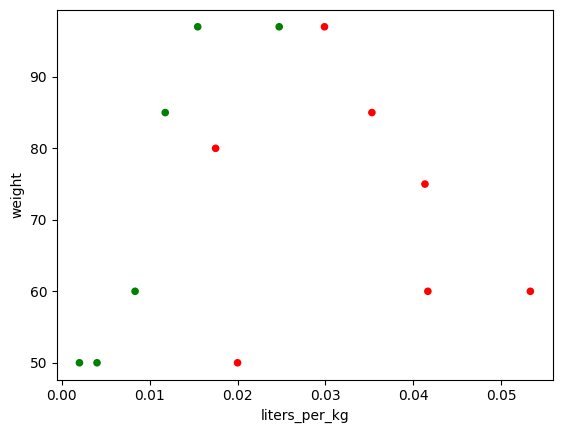

In [55]:
# Data preparation (calculate something)
df_transformed = df.copy()
df_transformed['liters_per_kg'] = df_transformed['liters_of_beer'] / df_transformed['weight']

df_transformed.plot.scatter('liters_per_kg', 'weight', c=['green' if wasted == 0 else 'red' for wasted in df['wasted']])

In [56]:
# Do the ML training thing
X_train, X_test, y_train, y_test = train_test_split(df_transformed.drop(['wasted'], axis=1), df_transformed['wasted'])
model = RandomForestRegressor(n_estimators=1, max_depth=4, max_features=3).fit(X_train, y_train)
mean_absolute_error(y_test, model.predict(X_test))

0.5

In [57]:
# Make an inference
df_new = pd.DataFrame([
    [60, 0.1],
    [60, 5],
], columns=['weight', 'liters_of_beer'])

df_new_transformed = df_new.copy()
df_new_transformed['liters_per_kg'] = df_new_transformed['liters_of_beer'] / df_new_transformed['weight']

model.predict(df_new_transformed)

array([0., 1.])

# Using Feast

running locally, with file-based storage

In [25]:
#!pip install feast

In [26]:
#!feast init "feast_tutorial"

In [ ]:
# TODO

# Using Databricks
This code only runs within the databricks notebooks

suposes the prior existance of:
1. Catalog named `test_databricks`
2. Schema named `default`

The workspace should be Premium or Enterprise

In [ ]:
from databricks import feature_store
from databricks.feature_engineering import FeatureFunction
import mlflow
mlflow.autolog()
mlflow.set_experiment("/Users/lsbenitezpereira@gmail.com/tutorial_feature_store")

In [ ]:
%sql
-- Register feature
CREATE OR REPLACE FUNCTION test_databricks.default.calculate_liters_per_kg(liters_of_beer DOUBLE, weight BIGINT)
RETURNS DOUBLE
LANGUAGE PYTHON
AS $$
return liters_of_beer / weight
$$


In [ ]:
# Prepare data (calculate something)
fs = feature_store.FeatureStoreClient()
dataset_with_feature_metadata = fs.create_training_set(
    df=spark.createDataFrame(df),
    feature_lookups= [
        FeatureFunction(
            udf_name="test_databricks.default.calculate_liters_per_kg",
            output_name="liters_per_kg",
            input_bindings={
                'liters_of_beer': 'liters_of_beer',
                'weight': 'weight',
            },
        )
    ],
    label = 'wasted',
)

df_transformed = dataset_with_feature_metadata.load_df().toPandas()
df_transformed


In [ ]:
with mlflow.start_run() as run:
    run_id = run.info.run_id

    # Do the ML thing
    X_train, X_test, y_train, y_test = train_test_split(df_transformed.drop(['wasted'], axis=1), df_transformed['wasted'])
    model = RandomForestRegressor(n_estimators=1, max_depth=5, max_features=3).fit(X_train, y_train)
    mean_absolute_error(y_test, model.predict(X_test))

    fs.log_model(
        model=model,
        artifact_path="model",
        flavor=mlflow.sklearn,
        training_set=dataset_with_feature_metadata,  # This is the magic step
    )

In [ ]:
# Make an inference
# No need to calculate features anymore... MIRACLE!!!
# The need of a transformation is already captured in the mlflow model metadata
# Therefore, MLflow can perform it automatically for you

df_new = pd.DataFrame([
    [60, 0.1],
    [60, 5],
], columns=['weight', 'liters_of_beer'])

fs.score_batch(
    model_uri=f"runs:/{run_id}/model",
    df=spark.createDataFrame(df_new),
).show()

# If you deploy to a databricks serving endpoint, the same happens
# You can make the inference with only:
# curl ... -d '{"inputs": [{"weight": 60, "liters_of_beer": 3.5}]}' https://<subdomain>.azuredatabricks.net/serving-endpoints/<name>/invocations